#### Hi! I’m Leonardo, an undergraduate Information Systems student with interest in Machine Learning and Data Science. If you’d like to learn more about my work, feel free to check my Linktree: https://linktr.ee/leoantero. Kind regards, Leo

For this project I will build a classifier with the book "Hands-on Machine Learning", where we'll identify the given number.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X = mnist['data']
y = mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

This means there are 70000 images each represented by 784 features (28x28 pixels).

Each feature corresponds to a number from 0 to 255 that represents the pixel color, 0 being white and 255 being black.

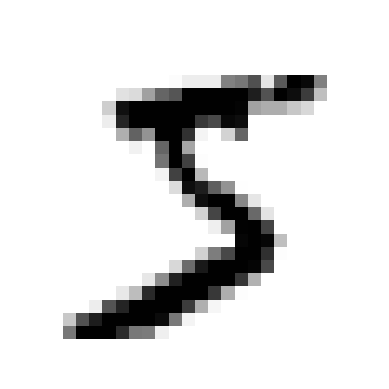

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

digit = X.iloc[0].to_numpy()
digit_image = digit.reshape(28, 28)

plt.imshow(digit_image, cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

So, this an example of the images of the dataset

In [5]:
# as the label are strings, we need to convert them to integers

y = y.astype(int)

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_classf = SGDClassifier(random_state=42)

Since the MNIST dataset is already splited into training and testing sets, we'll use this division. 

Also, the training set is already shuffled, this is great because it ensures a balanced distribution of digits, preventing issues for models that are sensitive to data ordering.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classification
#### First, let's classify specific digits

In [8]:
y_train_5 = (y_train == 5) # Creating specific datasets for the number 5
y_test_5 = (y_test == 5)
 # We are using Stochastic Gradient Descent Classifier
sgd_classf.fit(X_train, y_train_5)

sgd_classf.predict([X.iloc[0]])

C:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

As we need to evaluate our model perfomance, it is possible to use a lot of different metrics, but for now I will bring the confusion matrix approach

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_classf, X_train, y_train_5, cv = 3)

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

This means that:
    
    3530  we had true positive (predicted 5 and it is a 5)
    687 we had false positive (predicted 5 but isn't a 5)
    1891 we had false negative (predicted isn't 5 but it is a 5)
    53892 we had true negative (predicted isn't a 5 and isn't a 5)

Our objective building a classifier it is to make false positives and false negatives values turn into zeros, this means perfection.

Even though the confusion matrix doesn't seem to show so much information, we can extract relevant metrics with it, the models precision, recall and the F1-score.
    
    Precision: how accurate are the correct predictions
    Recall: how many % of the positives the model identify
    F1-score: harmonic mean of precision and recall

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision: ", precision_score(y_train_5, y_train_pred))
print("Recall: ", recall_score(y_train_5, y_train_pred))
print("F1 score: ", f1_score(y_train_5, y_train_pred))

Precision:  0.8370879772350012
Recall:  0.6511713705958311
F1 score:  0.7325171197343846


Each classifier has it's own threshold to decide whether it is positive or negative

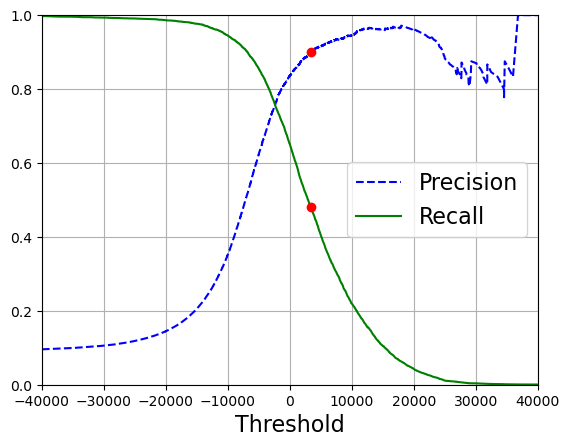

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import numpy as np

y_scores = cross_val_predict(sgd_classf, X_train, y_train_5, cv = 3, method='decision_function')
precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')

    plt.plot([threshold_90_precision], [0.9], 'ro')
    plt.plot([threshold_90_precision], [recall_90], 'ro')

    plt.xlabel('Threshold', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 16)
    plt.xlim([-40000, 40000])
    plt.ylim([0, 1])
    plt.grid(True)

threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]
recall_90 = recalls[np.argmax(precision >= 0.90)]

plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

The threshold works like this: it is the limit the model uses to decide if a digit is a 5 or not. As the threshold is increased you gain precision, because the model becomes more selective, but there is a trade-off between precision and recall, while it reaches 90% precision the recall drops because the model is missing some real digits.

In [12]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

# The model has 90% precision, which is great!

0.9000345901072293

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classf, X_train, y_train_5, cv = 3, scoring='roc_auc')

When deciding to use the precision/recall or the ROC curve, generally you should choose precision/recall whenever the positive class is rare and the false positives are more relevant than the false negatives.
For instance, when building a fraud detection model it is better to have more false positives (high recall).

## Multiclass Classification
#### Now, it's time to identify different classes.

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
ovo_clf_rf = OneVsOneClassifier(RandomForestClassifier(random_state = 42))
ovo_clf_rf.fit(X_train, y_train)
ovo_clf_rf.predict(X.iloc[[0]])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(ovo_clf_rf, X_train, y_train, cv = 3, scoring='accuracy')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(ovo_clf_rf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.96405, 0.96185, 0.9649 ])

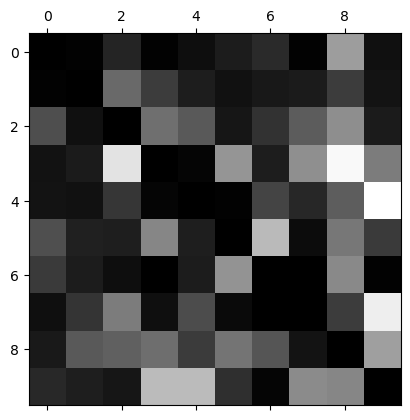

In [27]:
y_train_pred = cross_val_predict(ovo_clf_rf, X_train_scaled, y_train, cv = 3)
cf_mtx = confusion_matrix(y_train, y_train_pred)
row_sums = cf_mtx.sum(axis=1, keepdims = True)
norm_cf_mtx = cf_mtx / row_sums
np.fill_diagonal(norm_cf_mtx, 0)

plt.matshow(norm_cf_mtx, cmap=plt.cm.gray)
plt.show()

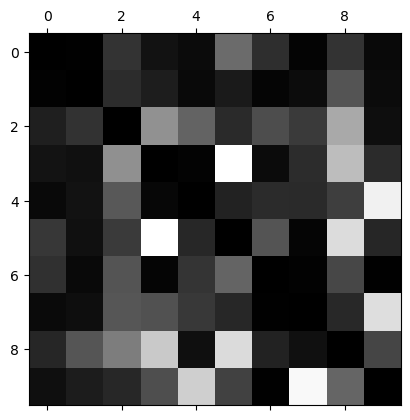

In [28]:
ovo_sgd = OneVsOneClassifier(SGDClassifier())
ovo_sgd.fit(X_train_scaled, y_train)

y_train_pred = cross_val_predict(ovo_sgd, X_train_scaled, y_train, cv = 3)
cf_mtx = confusion_matrix(y_train, y_train_pred)
row_sums = cf_mtx.sum(axis=1, keepdims = True)
norm_cf_mtx = cf_mtx / row_sums
np.fill_diagonal(norm_cf_mtx, 0)

plt.matshow(norm_cf_mtx, cmap=plt.cm.gray)
plt.show()

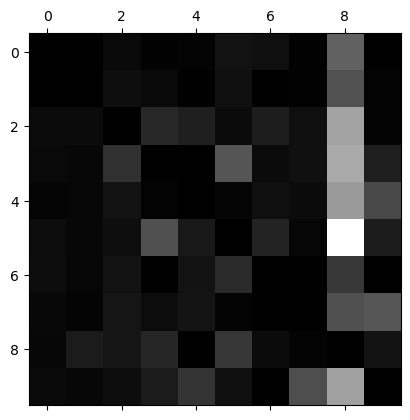

In [29]:
sgd_classf.fit(X_train_scaled, y_train)
y_train_pred = cross_val_predict(sgd_classf, X_train_scaled, y_train, cv = 3)
cf_mtx = confusion_matrix(y_train, y_train_pred)
row_sums = cf_mtx.sum(axis=1, keepdims = True)
norm_cf_mtx = cf_mtx / row_sums
np.fill_diagonal(norm_cf_mtx, 0)

plt.matshow(norm_cf_mtx, cmap=plt.cm.gray)
plt.show()

Interpretation of these matrixes: scattered bright spots means the model isn't working properly with these digits.

This indicates that the best model was the SGDClassifier withouth the OvO strategy, as it had the fewer scattered erros. Well, you may be wondering "why this happens", and this probably was a consequence of the OvO complexity, what lead to scattered noise in the matrix if many pairs have slight ambiguities.

## Multilabel classification

Until now, each instance was assigned to just one class. But, what if we want to ask to questions at the same time?

Here, the y_multilabel is created to train a KNN Classifier and predict two things at the same time, whether the number is large (higher than 6) and whether it is odd.

In [32]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict(X.iloc[[0]])

c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

In [34]:
# Evaluating the multilabel classifier  using f1 score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

0.976410265560605

If there is a huge difference in the amount of data each class has, you can set average='weighted'.

## Multioutput classification

Each label in the multilabel classification can have more than two classes. To do this, we'll build a model that blurs the image and after tries to rebuild it. It is a multioutput task because the model predicts the value of each pixel.

c:\Users\Leonardo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


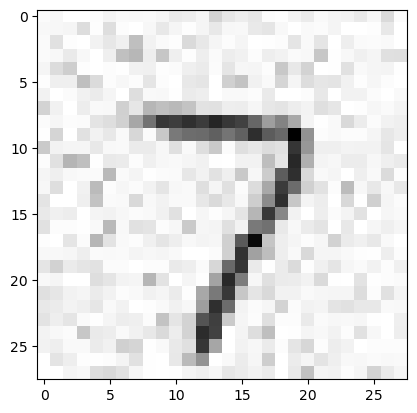

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_ns = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_ns = X_test + noise
y_train_ns = X_train_ns
y_test_ns = X_test_ns

knn_clf.fit(X_train_ns, y_train_ns)
clean = knn_clf.predict(X_test_ns.iloc[[0]])
image = clean.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.binary, interpolation='nearest')

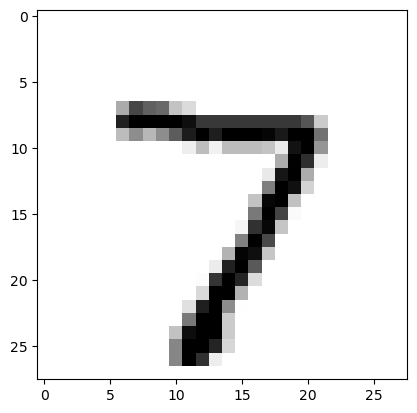

In [44]:
image = X_test.iloc[0].values.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.binary, interpolation='nearest')

Predicted exactly what should be !